In [1]:
import stl
from stl import mesh
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint

In [2]:
your_mesh0 = mesh.Mesh.from_file("square.stl")
your_mesh1 = mesh.Mesh.from_file("circle.stl")
#volume, cog, inertia = your_mesh0.get_mass_properties()
np.min(your_mesh0.x)

0.0

In [3]:
def to2Dlize(your_mesh0):
    mesh2D0=np.zeros([len(your_mesh0[:,0]),6])
    for i in range(len(your_mesh0)):
        mesh2D0[i,0]=your_mesh0[i,0]
        mesh2D0[i,1]=your_mesh0[i,1]
        mesh2D0[i,2]=your_mesh0[i,3]
        mesh2D0[i,3]=your_mesh0[i,4]
        mesh2D0[i,4]=your_mesh0[i,6]
        mesh2D0[i,5]=your_mesh0[i,7]
    return mesh2D0

mesh2d0=to2Dlize(your_mesh0)
mesh2d1=to2Dlize(your_mesh1)


def center(mesh2d):
    mesh2d=np.reshape(mesh2d,(mesh2d.shape[0],3,2))
    xmin=np.min(mesh2d[:,:,0])
    xmax=np.max(mesh2d[:,:,0])
    ymax=np.max(mesh2d[:,:,1])
    ymin=np.min(mesh2d[:,:,1])
    mesh2d[:,:,0]=mesh2d[:,:,0]-(xmax+xmin)/2
    mesh2d[:,:,1]=mesh2d[:,:,1]-(ymax+ymin)/2
    return np.reshape(mesh2d,(mesh2d.shape[0],6))
    
mesh2d0=center(mesh2d0)
mesh2d1=center(mesh2d1)



def rescale(a,b,t):
    return a+(b-a)*t

def isintriangle(triangle,point):
    def sign(p1,p2,p3):
        return (p1[0] - p3[0]) * (p2[0] - p3[0]) - (p2[0] - p3[0]) * (p1[0] - p3[0]);
    
    d1=sign(point,triangle[0],triangle[1])
    d2=sign(point,triangle[1],triangle[2])
    d3=sign(point,triangle[2],triangle[0])
    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0);
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0);
    
    return not(has_neg and has_pos)

def isinmesh(point,mesh):
    mesh=np.reshape(mesh,(mesh.shape[0],3,2))
    for i in range(mesh.shape[0]):
        if isintriangle(mesh[i],point):
            return True
    return False



def sample(mesh,npoints):
    ###Find a square containing it
    xmax=-np.inf
    ymax=-np.inf
    xmin=np.inf
    ymin=np.inf
    for i in range(len(mesh)):
        xmaxtemp=np.max(mesh[i,0::2])
        xmintemp=np.min(mesh[i,0::2])
        if xmaxtemp>=xmax:
            xmax=xmaxtemp
        if xmintemp<=xmin:
            xmin=xmintemp
        ymaxtemp=np.max(mesh[i,1::2])
        ymintemp=np.min(mesh[i,1::2])

        if ymaxtemp>=ymax:
            ymax=ymaxtemp
        if ymintemp<=ymin:
            ymin=ymintemp

        
    points=np.zeros([npoints,2])
    k=0
    h=0
    #####Add points inside the mesh to a vector
    while k<npoints:
        h=h+1;
        point=np.array([rescale(xmin,xmax,np.random.rand()),rescale(ymin,ymax,np.random.rand())])
        if (isinmesh(point,mesh)):
            points[k]=point
            k=k+1
    areasquare=np.linalg.norm(xmax-xmin)*np.linalg.norm(ymax-xmin)
    ###MCMC integration
    area=areasquare*k/h
    return points,area

M1num,_=sample(mesh2d1,100)
M0num,area0=sample(mesh2d0,10000)
v=(area0/M1num.shape[0])*np.ones(M1num.shape[0])
w=np.zeros(M1num.shape[0])

def computeVoronoi(M0num,M1num,w):
    Vor=np.zeros(M0num.shape[0])
    for i in range(M0num.shape[0]):
        Vor[i]=int(np.argmin(np.array([np.linalg.norm(M0num[i]-M1num[j])**2-w[j] for j in range(M1num.shape[0])])))
    return Vor  

def centroids(M0num,M1num,w):
    V=computeVoronoi(M0num,M1num,w).astype(int)
    centroid=np.zeros([M1num.shape[0],2])
    counter=np.zeros(M1num.shape[0])
    for j in range(M0num.shape[0]):
        centroid[V[j]]=centroid[V[j]]+M0num[j]
        counter[V[j]]=counter[V[j]]+1
    for j in range(M1num.shape[0]): 
        if counter[j]!=0:
            centroid[j]=centroid[j]/counter[j]
    return centroid

def G(w,M0num,M1num,v,area0):
    Vor=computeVoronoi(M0num,M1num,w).astype(int)
    temp=np.zeros(M1num.shape[0])
    area=np.zeros(M1num.shape[0])
    h=np.zeros(M1num.shape[0])
    for j in range(M0num.shape[0]):
        temp[Vor[j]]=temp[Vor[j]]+np.linalg.norm(M1num[Vor[j]]-M0num[j])**2
        h[Vor[j]]=h[Vor[j]]+1
    
    temp1=0
    for i in range(M1num.shape[0]):
        if h[i]!=0:
            area[i]=area0*h[i]/M0num.shape[0]
            temp[i]=temp[i]*(area[i])/h[i]-w[i]*area[i]+w[i]*v[i]
        else:
            temp[i]=w[i]*v[i]
        temp1=temp1+temp[i]
    
    return temp1

def deltaG(w,M0num,M1num,v,area0):
    Vor=computeVoronoi(M0num,M1num,w).astype(int)
    area=np.zeros(M1num.shape[0])
    h=np.zeros(M1num.shape[0])
    gradient=np.zeros(M1num.shape[0])

    for j in range(M0num.shape[0]):
        h[Vor[j]]=h[Vor[j]]+1
    
    for i in range(M1num.shape[0]):
        area[i]=area0*h[i]/M0num.shape[0]
        gradient[i]=(area[i]+v[i])
    
    return gradient

nlc = NonlinearConstraint(lambda w : np.linalg.norm(w), 0, 1)

fG=lambda w: G(w,M0num,M1num,v,area0)
fdeltaG=lambda w: deltaG(w,M0num,M1num,v,area0)
print("start optimizing")
wopt = minimize(fG, w, jac=fdeltaG, constraints=(nlc,),
               options={'gtol': 1e-6, 'disp': True, 'maxiter': 100})


start optimizing


/tmp/ipykernel_107823/3150383900.py:155: OptimizeWarning: Unknown solver options: gtol
  wopt = minimize(fG, w, jac=fdeltaG, constraints=(nlc,),


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.004675263225618551
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1


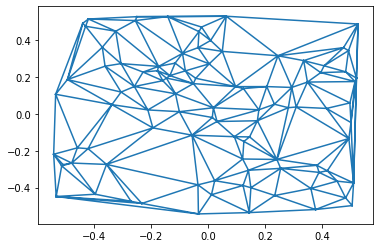

In [4]:
from scipy.spatial import Delaunay
w=wopt.x
centroid=centroids(M0num,M1num,w)
tri=Delaunay(M1num)
plt.triplot(M1num[:,0], M1num[:,1], tri.simplices)
#plt.triplot(centroid[:,0], centroid[:,1], tri.simplices)


<IPython.core.display.Javascript object>


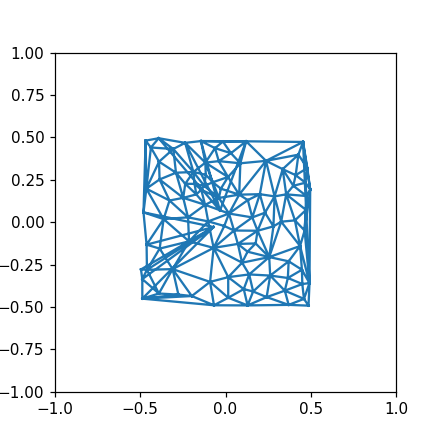

In [5]:
%matplotlib notebook
import matplotlib.animation as animation
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))


def update(frame):
    ax.clear()

    ax.triplot(frame/100*M1num[:,0]+(1-frame/100)*centroid[:,0],frame/100*M1num[:,1]+(1-frame/100)*centroid[:,1], tri.simplices)
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    
ani = animation.FuncAnimation(fig,update,range(100), blit = False)
